# 1. Importa√ß√£o de Bibliotecas e Leitura dos Dados

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from statsmodels.api import Logit
import statsmodels.api as sm
import time
from tqdm import tqdm

sns.set_theme(style="darkgrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)

import warnings
warnings.filterwarnings("ignore")

In [7]:
path_mensalidades = '..\\data\\mensalidades_teste.csv'
path_cobranca = '..\\data\\cobrancas_teste.csv'

df_mensalidades = pd.read_csv(path_mensalidades)
df_cobranca = pd.read_csv(path_cobranca)

# 2. Prepara√ß√£o das vari√°veis

In [8]:
# Convers√£o de colunas de datas
date_columns_mensalidades = ['data_competencia', 'data_vencimento', 'data_baixa']
for col in date_columns_mensalidades:
    df_mensalidades[col] = pd.to_datetime(df_mensalidades[col], errors='coerce')

df_cobranca['data_cobranca'] = pd.to_datetime(df_cobranca['data_cobranca'], errors='coerce')


df_merged = df_cobranca.merge(df_mensalidades, on='id_aluno', how='left')

# Criar coluna indicando se a cobran√ßa resultou em pagamento
df_merged['pagou_apos_cobranca'] = df_merged['data_baixa'].notnull().astype(int)

# Criar colunas de tratamento para cada tipo de cobran√ßa
df_merged['tratamento_whatsapp'] = (df_merged['acao_cobranca'] == 'whatsapp').astype(int)
df_merged['tratamento_email'] = (df_merged['acao_cobranca'] == 'e-mail').astype(int)
df_merged['tratamento_sms'] = (df_merged['acao_cobranca'] == 'SMS').astype(int)

# Criar novas features
df_merged['dias_atraso'] = (pd.Timestamp.today() - df_merged['data_vencimento']).dt.days
df_merged['num_cobrancas'] = df_merged.groupby('id_aluno')['acao_cobranca'].transform('count')

# 2. Propensity Score Matching (PSM)

In [9]:
features_psm = ['valor_cobrado', 'dias_atraso', 'num_cobrancas']
X_psm = df_merged[features_psm]

def aplicar_psm(tratamento):
    y_psm = df_merged[tratamento]
    psm_model = LogisticRegression()
    psm_model.fit(X_psm, y_psm)
    df_merged[f'propensity_score_{tratamento}'] = psm_model.predict_proba(X_psm)[:, 1]
    
    nn = NearestNeighbors(n_neighbors=1)
    treated = df_merged[df_merged[tratamento] == 1]
    control = df_merged[df_merged[tratamento] == 0]
    
    nn.fit(control[[f'propensity_score_{tratamento}']])
    distances, indices = nn.kneighbors(treated[[f'propensity_score_{tratamento}']])
    matched_control = control.iloc[indices.flatten()]
    
    df_matched = pd.concat([treated, matched_control])
    
    model_causal = sm.OLS(df_matched['pagou_apos_cobranca'], sm.add_constant(df_matched[tratamento]))
    results = model_causal.fit()
    print(f"\nResultados para {tratamento}:")
    print(results.summary())
    
    return df_matched

# Aplicar PSM para cada tratamento
df_matched_whatsapp = aplicar_psm('tratamento_whatsapp')
df_matched_email = aplicar_psm('tratamento_email')
df_matched_sms = aplicar_psm('tratamento_sms')


Resultados para tratamento_whatsapp:
                             OLS Regression Results                            
Dep. Variable:     pagou_apos_cobranca   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     9.140
Date:                 Thu, 27 Feb 2025   Prob (F-statistic):            0.00250
Time:                         17:19:53   Log-Likelihood:            -3.0522e+06
No. Observations:              4743462   AIC:                         6.104e+06
Df Residuals:                  4743460   BIC:                         6.105e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

# 3. Visualiza√ß√£o da distribui√ß√£o do Propensity Score

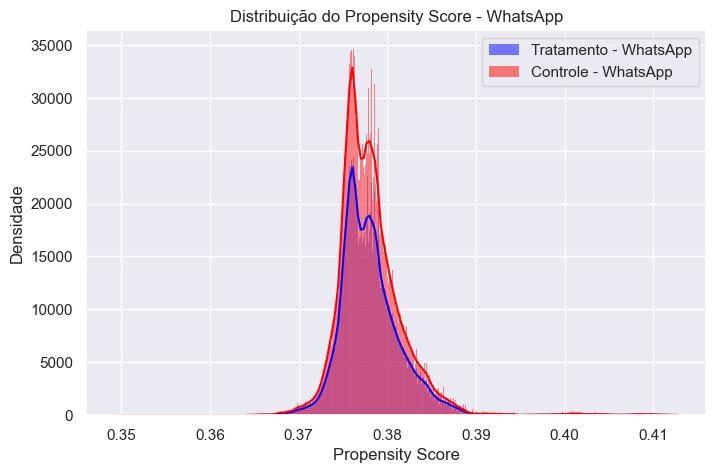

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df_merged[df_merged['tratamento_whatsapp'] == 1]['propensity_score_tratamento_whatsapp'], color='blue', kde=True, label='Tratamento - WhatsApp')
sns.histplot(df_merged[df_merged['tratamento_whatsapp'] == 0]['propensity_score_tratamento_whatsapp'], color='red', kde=True, label='Controle - WhatsApp')
plt.xlabel('Propensity Score')
plt.ylabel('Densidade')
plt.legend()
plt.title('Distribui√ß√£o do Propensity Score - WhatsApp')
plt.show()

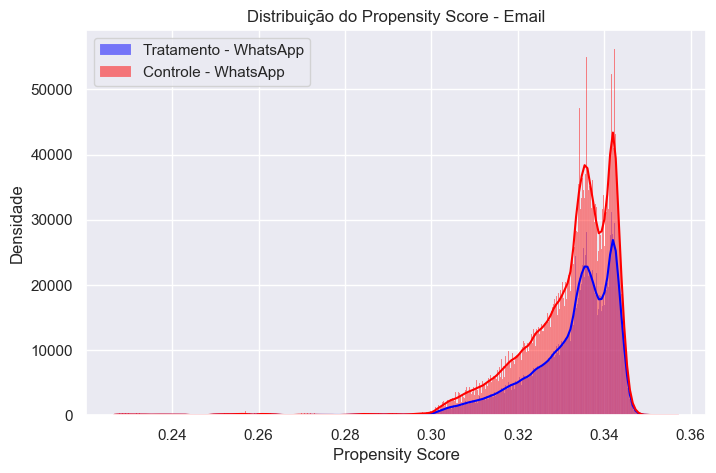

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_merged[df_merged['tratamento_email'] == 1]['propensity_score_tratamento_email'], color='blue', kde=True, label='Tratamento - Email')
sns.histplot(df_merged[df_merged['tratamento_email'] == 0]['propensity_score_tratamento_email'], color='red', kde=True, label='Controle - Email')
plt.xlabel('Propensity Score')
plt.ylabel('Densidade')
plt.legend()
plt.title('Distribui√ß√£o do Propensity Score - Email')
plt.show()

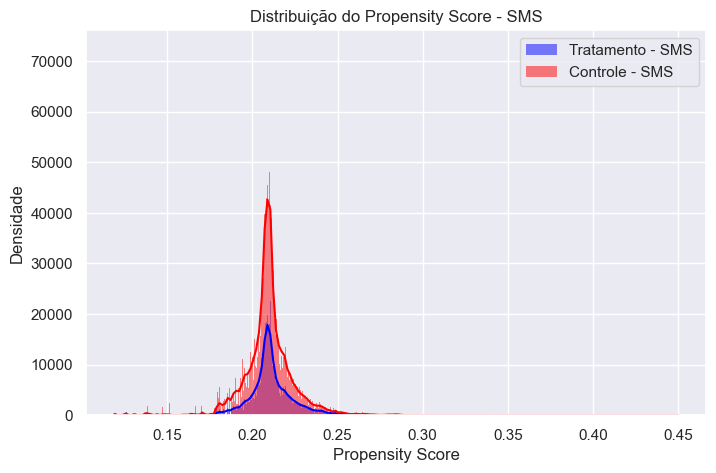

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df_merged[df_merged['tratamento_sms'] == 1]['propensity_score_tratamento_sms'], color='blue', kde=True, label='Tratamento - SMS')
sns.histplot(df_merged[df_merged['tratamento_sms'] == 0]['propensity_score_tratamento_sms'], color='red', kde=True, label='Controle - SMS')
plt.xlabel('Propensity Score')
plt.ylabel('Densidade')
plt.legend()
plt.title('Distribui√ß√£o do Propensity Score - SMS')
plt.show()

# 4. Compara√ß√£o das taxas de pagamento entre grupos

In [11]:
def comparar_taxas(df_matched, tratamento):
    tratamento_mean = df_matched[df_matched[tratamento] == 1]['pagou_apos_cobranca'].mean()
    controle_mean = df_matched[df_matched[tratamento] == 0]['pagou_apos_cobranca'].mean()
    print(f"Taxa de pagamento - {tratamento} (Tratamento): {tratamento_mean:.2%}")
    print(f"Taxa de pagamento - {tratamento} (Controle): {controle_mean:.2%}")

comparar_taxas(df_matched_whatsapp, 'tratamento_whatsapp')
comparar_taxas(df_matched_email, 'tratamento_email')
comparar_taxas(df_matched_sms, 'tratamento_sms')

Taxa de pagamento - tratamento_whatsapp (Tratamento): 69.42%
Taxa de pagamento - tratamento_whatsapp (Controle): 69.55%
Taxa de pagamento - tratamento_email (Tratamento): 71.28%
Taxa de pagamento - tratamento_email (Controle): 71.29%
Taxa de pagamento - tratamento_sms (Tratamento): 74.55%
Taxa de pagamento - tratamento_sms (Controle): 74.58%


# 5. Relat√≥rio Final

## Introdu√ß√£o

Neste estudo, meu objetivo foi analisar se as diferentes estrat√©gias de cobran√ßa (WhatsApp, E-mail e SMS) t√™m um **impacto causal** sobre a taxa de pagamento das mensalidades. Para isso, utilizei t√©cnicas de **Infer√™ncia Causal**, como **Propensity Score Matching (PSM)** e **Regress√£o OLS**, garantindo que os resultados fossem mais confi√°veis e n√£o apenas correla√ß√µes esp√∫rias.

---

## Desafios da Infer√™ncia Causal

Inferir causalidade neste cen√°rio apresentou **tr√™s grandes desafios**:

### 1. Vi√©s de Sele√ß√£o
As cobran√ßas **n√£o foram distribu√≠das aleatoriamente**. Ou seja, alunos que receberam uma cobran√ßa podem ter caracter√≠sticas distintas dos que n√£o receberam, tornando dif√≠cil separar **efeitos reais de cobran√ßa** de outros fatores subjacentes.

### 2. Vari√°veis N√£o Observadas
Fatores como **hist√≥rico financeiro, comportamento de pagamento ou suporte financeiro familiar** podem influenciar as decis√µes de pagamento. Como esses dados n√£o estavam dispon√≠veis, foi necess√°rio controlar o m√°ximo poss√≠vel por meio do **Propensity Score Matching (PSM)**.

### 3. Distribui√ß√£o do Propensity Score
A distribui√ß√£o dos scores mostrou que os grupos **tratado e controle eram muito semelhantes**. Isso sugere que as cobran√ßas podem n√£o estar sendo direcionadas com um crit√©rio claro, dificultando a identifica√ß√£o de efeitos reais.

Para minimizar esses problemas, utilizei **PSM** para criar grupos compar√°veis e **Regress√£o OLS** para estimar os efeitos das cobran√ßas na taxa de pagamento.

---

## Resultados da An√°lise

### 1. **Impacto das Estrat√©gias de Cobran√ßa** (Regress√£o OLS)

Os coeficientes abaixo representam o impacto das cobran√ßas sobre a taxa de pagamento:

| Estrat√©gia   | Coeficiente  | P-valor  | Conclus√£o |
|-------------|-------------|----------|-------------|
| **WhatsApp**  | **-0.0013** | **0.003** | Pequeno efeito negativo, estatisticamente significativo. |
| **E-mail**    | **-0.00003** | **0.94** | Efeito nulo, sem impacto. |
| **SMS**       | **-0.0003**  | **0.528** | Efeito nulo, sem impacto. |

üìå **Conclus√£o:** Nenhuma das cobran√ßas teve um impacto positivo significativo na taxa de pagamento.

### 2. **Compara√ß√£o das Taxas de Pagamento**

| Estrat√©gia   | Tratamento (%) | Controle (%) | Diferen√ßa Absoluta |
|-------------|--------------|-------------|-------------------|
| **WhatsApp**  | **69.42%**  | **69.55%**  | **-0.13%** |
| **E-mail**    | **71.28%**  | **71.29%**  | **-0.01%** |
| **SMS**       | **74.55%**  | **74.58%**  | **-0.03%** |

üìå **Conclus√£o:** Nenhuma das cobran√ßas alterou significativamente a taxa de pagamento. 

---

## Recomenda√ß√µes

Com base nos resultados, recomendo as seguintes mudan√ßas nas estrat√©gias de cobran√ßa:

1. **Evitar cobran√ßas massivas indiscriminadas**, pois elas n√£o aumentam a taxa de pagamento.
2. **Personalizar as mensagens**, testando diferentes abordagens e linguagem para engajamento.
3. **Aumentar a variedade de canais**, incluindo chamadas telef√¥nicas e mensagens com incentivos financeiros (ex: desconto para pagamentos antecipados).

Para validar essas recomenda√ß√µes, sugiro um **teste A/B controlado**.

---

## Desenho do Teste A/B

Para avaliar se abordagens personalizadas de cobran√ßa s√£o mais eficazes, desenharia um **experimento A/B**:

1Ô∏è‚É£ **Grupo Controle (A):** Alunos que **n√£o recebem cobran√ßas adicionais**.  
2Ô∏è‚É£ **Grupo Tratamento (B):** Alunos que recebem cobran√ßas, mas de forma **estrategicamente modificada**:
   - **WhatsApp:** Testar mensagens personalizadas, tom mais persuasivo.
   - **E-mail:** Incluir incentivos como descontos por pagamento antecipado.
   - **SMS:** Testar urg√™ncia e call-to-action mais claros.

### **üìä M√©tricas a Acompanhar**

1. **Taxa de Pagamento:** A cobran√ßa aumentou a taxa de pagamento?
2. **Tempo M√©dio at√© o Pagamento:** Reduziu o tempo para quitar a mensalidade?
3. **Custo-benef√≠cio da Cobran√ßa:** Qual abordagem tem melhor retorno financeiro?
4. **Taxa de Reclama√ß√µes ou Descadastros:** Os alunos est√£o reagindo negativamente a alguma abordagem?

---

## Conclus√£o Final

Minha an√°lise mostrou que **as cobran√ßas atualmente implementadas n√£o est√£o gerando um efeito causal positivo na taxa de pagamento**. Para melhorar os resultados, √© essencial **testar novas abordagens**, segmentar os alunos com maior risco de inadimpl√™ncia e monitorar os efeitos de cobran√ßas personalizadas em um experimento A/B controlado.
